### Name :- Darpan Gaur
### Roll Number :- CO21BTECH11004
<small>Reference :- `https://medium.com/@sayedebad.777/ddpm-pytorch-implementation-from-scratch-36b647f5dd82`</small>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time

import json

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torchvision

from torch import nn, optim
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from sklearn.manifold import TSNE

In [2]:
# seed 
seed = 17
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# set device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

## Conv, Resnet, Attention, Encoder, Decoder for UNET

In [4]:
# Conv block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.norm = nn.GroupNorm(8, in_channels)
        self.act = nn.SiLU()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        return self.conv(self.act(self.norm(x)))

# Time embedding
class TimeEmbedding(nn.Module):
    def __init__(self, d_in, d_out):
        super(TimeEmbedding, self).__init__()
        self.act = nn.SiLU()
        self.proj = nn.Linear(d_in, d_out)

    def forward(self, t):
        return self.proj(self.act(t))
    


In [5]:
# ResNet block
class ResBlock(nn.Module):
    def __init__(self, in_C, out_C, t_emb_dim):
        super(ResBlock, self).__init__()
        self.conv1 = ConvBlock(in_C, out_C)
        self.conv2 = ConvBlock(out_C, out_C)
        self.t_emb = TimeEmbedding(t_emb_dim, out_C)
        self.residual = nn.Conv2d(in_C, out_C, kernel_size=1)

    def forward(self, x, t):
        x1 = self.conv1(x)
        x1 = x1 + self.t_emb(t)[:, :, None, None]
        x2 = self.conv2(x1)
        x2 = x2 + self.residual(x)
        return x2
    
# Attention block
class AttentionBlock(nn.Module):
    def __init__(self, C, n_heads):
        super(AttentionBlock, self).__init__()
        self.norm = nn.GroupNorm(8, C)
        self.multihead = nn.MultiheadAttention(C, n_heads, batch_first=True)

    def forward(self, x):
        batch_size, channels, h, w = x.shape
        in_attn = x.reshape(batch_size, channels, h * w)
        in_attn = self.norm(in_attn)
        in_attn = in_attn.transpose(1, 2)
        out_attn, _ = self.multihead(in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        return x + out_attn

In [6]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1, down_sample=True):
        super().__init__()
        self.num_layers = num_layers
        self.downSamp = down_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                ResBlock(in_channels if i == 0 else out_channels, out_channels, t_emb_dim)
                for i in range(num_layers)
            ]
        )
        self.attention_blocks = nn.ModuleList(
            [
                AttentionBlock(out_channels, num_heads)
                for _ in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, 4, 2, 1) if self.downSamp else nn.Identity()

    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            out = self.resnet_conv_first[i](out, t_emb)
            out = self.attention_blocks[i](out)
        out = self.down_sample_conv(out)
        return out

In [7]:
# Mid block
class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.resnet_conv_first = nn.ModuleList(
            [
                ResBlock(in_channels if i == 0 else out_channels, out_channels, t_emb_dim)
                for i in range(num_layers+1)
            ]
        )
        self.attention_blocks = nn.ModuleList(
            [
                AttentionBlock(out_channels, num_heads)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x, t_emb):
        out = x
        out = self.resnet_conv_first[0](out, t_emb)
        for i in range(self.num_layers):
            out = self.attention_blocks[i](out)
            out = self.resnet_conv_first[i+1](out, t_emb)
        return out

In [8]:
# up block
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1, up_sample=True):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                ResBlock(in_channels if i == 0 else out_channels, out_channels, t_emb_dim)
                for i in range(num_layers)
            ]
        )
        self.attention_blocks = nn.ModuleList(
            [
                AttentionBlock(out_channels, num_heads)
                for _ in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, 4, 2, 1) if self.up_sample else nn.Identity()

    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        out = x
        for i in range(self.num_layers):
            out = self.resnet_conv_first[i](out, t_emb)
            out = self.attention_blocks[i](out)
        return out  

## Noise Scheduler to add/remove noise

In [9]:
class noiseAdderRemover:
    def __init__(self, tn, start, end):
        self.tn = tn
        self.b = torch.linspace(start, end, tn)
        self.a = 1.0 - self.b
    
    def addNoise(self, x, eps, t):
        batch_size = x.size(0)
        a_bar = torch.cumprod(self.a, dim=0)
        sq_a_bar = torch.sqrt(a_bar).to(device)[t].reshape(batch_size)
        sq_1_a_bar = torch.sqrt(1.0 - a_bar).to(device)[t].reshape(batch_size)

        for i in range(1, len(x.shape)):
            sq_a_bar = sq_a_bar.unsqueeze(-1)
            sq_1_a_bar = sq_1_a_bar.unsqueeze(-1)

        # Forward pass equation
        return sq_a_bar * x + sq_1_a_bar * eps
    
    def remNoise(self, x, eps_nod, t):
        a_bar = torch.cumprod(self.a, dim=0)
        sq_a_bar = torch.sqrt(a_bar).to(device)[t]
        sq_1_a_bar = torch.sqrt(1.0 - a_bar).to(device)[t]

        x0 = ((x - (sq_1_a_bar * eps_nod)) / sq_a_bar)
        x0 = torch.clamp(x0, -1.0, 1.0)

        mu = x - (self.b.to(device)[t] * eps_nod) / sq_1_a_bar
        mu = mu / sq_a_bar

        if t==0:
            return mu, x0
        else:
            var = (1-a_bar.to(device)[t-1]) / (1-a_bar.to(device)[t])
            var *= self.b.to(device)[t] 
            sig = torch.sqrt(var)
            z = torch.randn(x.shape).to(device)

            return mu + sig*z, x0

## Time embeddings

In [10]:
class projTimeEmbedding(nn.Module):
    def __init__(self, t_dim):
        super().__init__()
        self.linear = nn.Linear(t_dim, t_dim)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.linear(self.act(self.linear(x)))

In [11]:
def sinTimeEmb(t, dim):
    pos = t[:, None].repeat(1, dim//2)
    f = torch.arange(0, dim//2).to(device)
    f = 10000 ** (2 * f / dim)
    emb = pos / f
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
    return emb

## DDPM with UNET and Noise Scheduler

In [12]:
# DDPM
class DDPM(nn.Module):
    def __init__(self, inC, t_emb_dim, num_heads, encodeLayers, decodeLayers, midLayers, downSample, downLayersConf, midLayerConf):
        super(DDPM, self).__init__()
        self.t_emb_dim = t_emb_dim
        # encoder UNET
        self.encoder = nn.ModuleList(
            [
                DownBlock(downLayersConf[i], downLayersConf[i+1], t_emb_dim, num_heads, encodeLayers, downSample[i])
                for i in range(len(downLayersConf)-1)
            ]
        )

        # latent space UNET
        self.latentLayers = nn.ModuleList(
            [
                MidBlock(midLayerConf[i], midLayerConf[i+1], t_emb_dim, num_heads, midLayers)
                for i in range(len(midLayerConf)-1)
            ]
        )

        # decoder UNET
        self.decoder = nn.ModuleList(
            [
                UpBlock(downLayersConf[i]*2, downLayersConf[i-1] if i!=0 else 16, t_emb_dim, num_heads, decodeLayers, downSample[i])
                for i in reversed(range(len(downLayersConf)-1))
            ]
        )

        self.inpEmb = nn.Conv2d(inC, downLayersConf[0], 3, padding=(1, 1))
        self.t_emb_proj = projTimeEmbedding(t_emb_dim)
        self.outNorm = nn.GroupNorm(8, 16)
        self.outConv = nn.Conv2d(16, inC, 3, padding=1)
        self.act = nn.SiLU()

    def forward(self, x, t):
        out = self.inpEmb(x)
        t_emb = sinTimeEmb(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_emb_proj(t_emb)

        # Encoder
        encoderOut = []
        for encLayer in self.encoder:
            encoderOut.append(out)
            out = encLayer(out, t_emb)

        # Latent space
        for latentLayer in self.latentLayers:
            out = latentLayer(out, t_emb)

        # Decoder
        for decLayer in self.decoder:
            tempOut = encoderOut.pop()
            out = decLayer(out, tempOut, t_emb)

        out = self.outNorm(out)
        out = self.act(out)
        out = self.outConv(out)

        return out
        


## Dataloader

In [13]:
# load MINST dataset, train + test as dataset


# define a transform to normalize the data
transform_ = transforms.Compose([transforms.ToTensor()])

# download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform_)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform_)

BATCH_SIZE = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

## Training

In [14]:
def trainDDPM(model, trainloader, noiseAddRem, epochs, lr, output_dir='output'):
    # make output directory
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # open log file
    log_file = open(f"{output_dir}/log.txt", "w")
    
    # define optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_loss = np.inf
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for img, lbl in tqdm(trainloader):
            
            img = img.float().to(device)

            # sample timestep
            t = torch.randint(0, config['timeSteps'], (img.shape[0],)).to(device)

            # sample noise
            eps = torch.randn_like(img).to(device)

            # add noise
            img_noisy = noiseAddRem.addNoise(img, eps, t)

            optimizer.zero_grad()

            pred_noise = model(img_noisy, t)

            loss = criterion(pred_noise, eps)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch: {epoch}, Loss: {running_loss/len(trainloader)}")
        log_file.write(f"Epoch: {epoch}, Loss: {running_loss/len(trainloader)}\n")

        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), f"{output_dir}/best_model.pth")
    end_time = time.time()
    # save last model
    torch.save(model.state_dict(), f"{output_dir}/last_model.pth")
    log_file.write(f"Training time: {end_time-start_time}")
    log_file.close()

## Train for 500 TimeSteps

In [39]:
# read json config
config_path = '/export/home/darpan/work_dir/h2/config_T500.json'
with open(config_path, 'r') as f:
    config = json.load(f)

# Create the noise scheduler
scheduler = noiseAdderRemover(tn=config['timeSteps'],
                                    start=config['beta_start'],
                                    end=config['beta_end'])

In [40]:
# Instantiate the model
img_dim = config['Unet']['img_dim']
input_channels = config['Unet']['input_channels']
encodeLayers = config['Unet']['encode_layers']
latentLayers = config['Unet']['latent_layers']
decodeLayers = config['Unet']['decode_layers']
downSample = config['Unet']['down_sample']
decoderChannels = config['Unet']['decode_channels']
latentChannels = config['Unet']['latent_channels']
num_heads = config['Unet']['num_heads']
t_emb_dim = config['Unet']['t_emb_dim']

# model = Unet(model_config).to(device)
model = DDPM(input_channels, t_emb_dim, num_heads, encodeLayers, decodeLayers, latentLayers, downSample, decoderChannels, latentChannels).to(device)

In [41]:
trainDDPM(model, trainloader, scheduler, 15, 1e-4, 'T500')

  0%|          | 0/235 [00:00<?, ?it/s]

100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 0, Loss: 0.24241165401453668


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 1, Loss: 0.052929700134282415


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 2, Loss: 0.038307924758880695


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 3, Loss: 0.03329329747468867


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 4, Loss: 0.030838861570079278


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 5, Loss: 0.028780336662175807


100%|██████████| 235/235 [01:19<00:00,  2.95it/s]


Epoch: 6, Loss: 0.02767124876697013


100%|██████████| 235/235 [01:18<00:00,  2.98it/s]


Epoch: 7, Loss: 0.02673418917395967


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 8, Loss: 0.025992009210142684


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 9, Loss: 0.02548269902930615


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 10, Loss: 0.024985383989963125


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 11, Loss: 0.02439900108791412


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 12, Loss: 0.024219785337435438


100%|██████████| 235/235 [01:19<00:00,  2.94it/s]


Epoch: 13, Loss: 0.024230803327357515


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 14, Loss: 0.023608399103296564


## Train for 1000 TimeSteps

In [18]:
# read json config
config_path = '/export/home/darpan/work_dir/h2/config_T1000.json'
with open(config_path, 'r') as f:
    config = json.load(f)

# Create the noise scheduler
scheduler = noiseAdderRemover(tn=config['timeSteps'],
                                    start=config['beta_start'],
                                    end=config['beta_end'])

In [19]:
# Instantiate the model
img_dim = config['Unet']['img_dim']
input_channels = config['Unet']['input_channels']
encodeLayers = config['Unet']['encode_layers']
latentLayers = config['Unet']['latent_layers']
decodeLayers = config['Unet']['decode_layers']
downSample = config['Unet']['down_sample']
decoderChannels = config['Unet']['decode_channels']
latentChannels = config['Unet']['latent_channels']
num_heads = config['Unet']['num_heads']
t_emb_dim = config['Unet']['t_emb_dim']

# model = Unet(model_config).to(device)
model = DDPM(input_channels, t_emb_dim, num_heads, encodeLayers, decodeLayers, latentLayers, downSample, decoderChannels, latentChannels).to(device)

In [25]:
trainDDPM(model, trainloader, scheduler, 15, 1e-4, 'T1000')

  0%|          | 0/235 [00:00<?, ?it/s]

100%|██████████| 235/235 [01:19<00:00,  2.95it/s]


Epoch: 0, Loss: 0.21403182272581345


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 1, Loss: 0.045956940116717464


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 2, Loss: 0.03146735626332303


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 3, Loss: 0.02656335772827585


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 4, Loss: 0.024175064075500408


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 5, Loss: 0.02262048677719654


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 6, Loss: 0.021294821022038765


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 7, Loss: 0.020531356937073645


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 8, Loss: 0.01987944239393828


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 9, Loss: 0.01943032581042102


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 10, Loss: 0.01894384151760568


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 11, Loss: 0.01844825734324912


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 12, Loss: 0.018147437654911204


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 13, Loss: 0.0177296209010355


100%|██████████| 235/235 [01:19<00:00,  2.95it/s]


Epoch: 14, Loss: 0.017807025696210406


## Train for 1500 TimeSteps

In [42]:
# read json config
config_path = '/export/home/darpan/work_dir/h2/config_T1500.json'
with open(config_path, 'r') as f:
    config = json.load(f)

# Create the noise scheduler
scheduler = noiseAdderRemover(tn=config['timeSteps'],
                                    start=config['beta_start'],
                                    end=config['beta_end'])

In [43]:
# Instantiate the model
img_dim = config['Unet']['img_dim']
input_channels = config['Unet']['input_channels']
encodeLayers = config['Unet']['encode_layers']
latentLayers = config['Unet']['latent_layers']
decodeLayers = config['Unet']['decode_layers']
downSample = config['Unet']['down_sample']
decoderChannels = config['Unet']['decode_channels']
latentChannels = config['Unet']['latent_channels']
num_heads = config['Unet']['num_heads']
t_emb_dim = config['Unet']['t_emb_dim']

# model = Unet(model_config).to(device)
model = DDPM(input_channels, t_emb_dim, num_heads, encodeLayers, decodeLayers, latentLayers, downSample, decoderChannels, latentChannels).to(device)

In [44]:
trainDDPM(model, trainloader, scheduler, 15, 1e-4, 'T1500')

100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 0, Loss: 0.20834298931220743


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 1, Loss: 0.04151631153010307


100%|██████████| 235/235 [01:18<00:00,  2.98it/s]


Epoch: 2, Loss: 0.026607395185435073


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 3, Loss: 0.02221882731673565


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 4, Loss: 0.020234001721156403


100%|██████████| 235/235 [01:18<00:00,  2.99it/s]


Epoch: 5, Loss: 0.018462541291212782


100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


Epoch: 6, Loss: 0.017485781834322086


100%|██████████| 235/235 [01:19<00:00,  2.95it/s]


Epoch: 7, Loss: 0.016836420454560443


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 8, Loss: 0.01609611232230004


100%|██████████| 235/235 [01:18<00:00,  2.99it/s]


Epoch: 9, Loss: 0.01573600116720859


100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch: 10, Loss: 0.015520093859510219


100%|██████████| 235/235 [01:19<00:00,  2.95it/s]


Epoch: 11, Loss: 0.01497803770322749


100%|██████████| 235/235 [01:18<00:00,  2.99it/s]


Epoch: 12, Loss: 0.014550926207386433


100%|██████████| 235/235 [01:18<00:00,  2.98it/s]


Epoch: 13, Loss: 0.014420596347685824


100%|██████████| 235/235 [01:20<00:00,  2.93it/s]


Epoch: 14, Loss: 0.014270641103862449


## Que 2(a) 
### -> done, check above code blocks

## Que 2(b)

- Trained the DDPM model for 500, 1000, 1500 timesteps.
- Loss for different time steps is as follows:
    - t500: 0.2424-0.0236
    - t1000: 0.214-0.0178
    - t1500:
- The loss is decreasing with the increase in the number of time steps, keeping epochs constant, this show increase in the number of time steps is helping the model to learn more about the data and generate better results.
- More number of time steps will give better results as the model will be able to learn more about the data and will be able to generate better results.
- Less number of time steps will give blurry images, as noise is not removed properly.

- Refer to the deniosed images shown in Que 2(e) for comparison between 500, 1000, 1500 time steps.
- Diversity is more with lower number of time steps, as with high time steps, improves quality so diversity is less.

## Que 2(c)

In [15]:
## using 1000 timesteps
# read json config
config_path = '/export/home/darpan/work_dir/h2/config_T1000.json'
with open(config_path, 'r') as f:
    config = json.load(f)

# Create the noise scheduler
scheduler = noiseAdderRemover(tn=config['timeSteps'],
                                    start=config['beta_start'],
                                    end=config['beta_end'])

In [16]:
# Instantiate the model
img_dim = config['Unet']['img_dim']
input_channels = config['Unet']['input_channels']
encodeLayers = config['Unet']['encode_layers']
latentLayers = config['Unet']['latent_layers']
decodeLayers = config['Unet']['decode_layers']
downSample = config['Unet']['down_sample']
decoderChannels = config['Unet']['decode_channels']
latentChannels = config['Unet']['latent_channels']
num_heads = config['Unet']['num_heads']
t_emb_dim = config['Unet']['t_emb_dim']

# model = Unet(model_config).to(device)
model = DDPM(input_channels, t_emb_dim, num_heads, encodeLayers, decodeLayers, latentLayers, downSample, decoderChannels, latentChannels).to(device)

model.load_state_dict(torch.load('T1000/best_model.pth'))

/tmp/ipykernel_3501146/2687692526.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('T1000/best_model.pth'))


<All keys matched successfully>

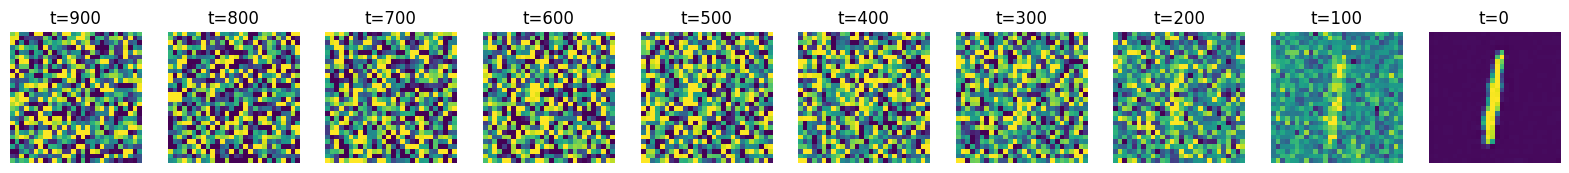

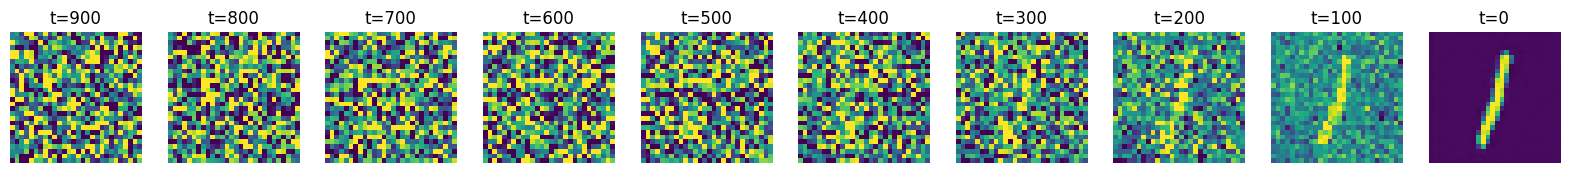

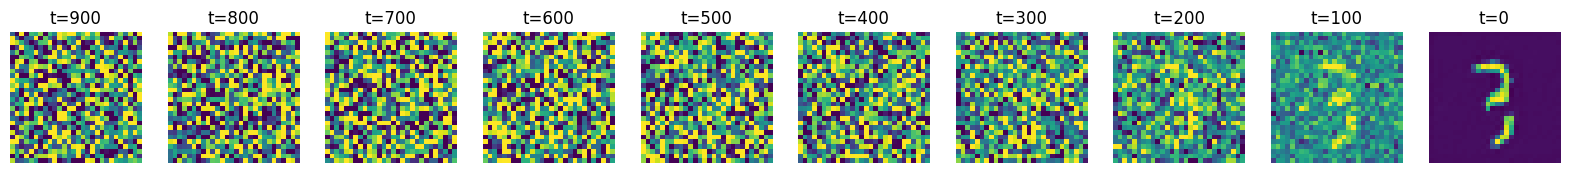

In [ ]:
for i in range(3):
    with torch.no_grad():
        # make 1x10 figure
        fig, ax = plt.subplots(1, 10, figsize=(20, 2))
        xt = torch.randn(1, 1, 28, 28).to(device)
        for ts in reversed(range(1000)):
            t = torch.as_tensor(i).unsqueeze(0).to(device)
            pred_noise = model(xt, t)

            xt, _ = scheduler.remNoise(xt, pred_noise, torch.as_tensor(i).to(device))

            ims = torch.clamp(xt, -1., 1.).detach().cpu()
            ims = (ims + 1) / 2

            if ts % 100 == 0:
                ax[9-ts//100].imshow(ims[0][0].cpu().numpy())
                ax[9-ts//100].axis('off')
                ax[9-ts//100].set_title('t={}'.format(ts))
        plt.show()

## Que 2(e)

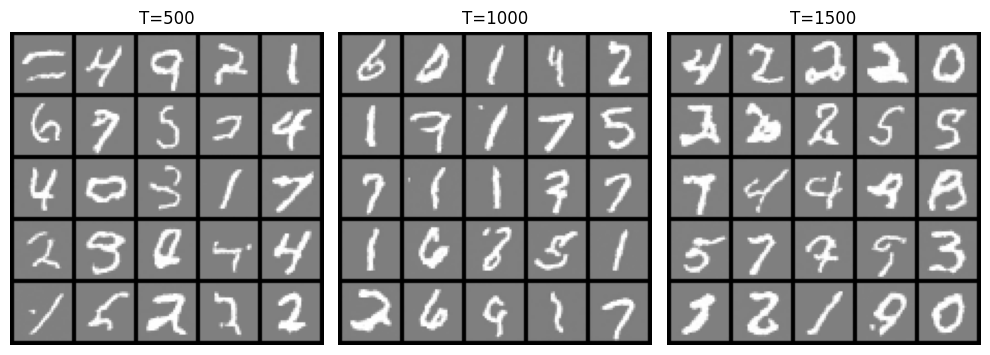

In [27]:
# load png image
from PIL import Image
img500 = Image.open('t500/x0_0.png')
img1000 = Image.open('t1000/x0_0.png')
img1500 = Image.open('t1500/x0_0.png')

# show images in 1x3 grid
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img500)
ax[0].axis('off')
ax[0].set_title('T=500')

ax[1].imshow(img1000)
ax[1].axis('off')
ax[1].set_title('T=1000')

ax[2].imshow(img1500)
ax[2].axis('off')
ax[2].set_title('T=1500')

# TIGHT LAYOUT
plt.tight_layout()

plt.show()

- Here quantative results are shown for 500, 1000, 1500 time steps.
- The images are generated using the trained model for 500, 1000, 1500 time steps, starting from the random noise.
- The model is able to generate better results with the increase in the number of time steps.
- We can see diversity and quality of the images generated by the model.
- Tried FID scroes but getting error, so not able to show the FID scores.